In [14]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [84]:
full_data = pd.read_csv('Full Data.txt', index_col = [0])

In [85]:
full_data

,gender,ajcc_pathologic_tumor_stage,tumor_status,DSS,DSS.time,TP53,TTN,FAT1,MUC16,CSMD3,...,NIPBL,CEACAM5,CEACAM6,CLCA4,EGFR,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,age
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,0,0.0,0.279452,822.678,1157.3300,1620.71,1004.4700,1.2325,...,1595.440,56.0776,423.3550,502.2340,722.847,92,8,0,2,1
TCGA-BA-4074,1,0,1,1.0,1.265753,1805.510,103.6870,6415.45,17.3422,0.3854,...,1605.890,153.3820,275.9330,12.7176,1267.900,106,8,0,1,1
TCGA-BA-4075,1,1,1,1.0,0.775342,383.760,295.9180,4162.40,1.0720,36.9824,...,907.410,18.2232,45.5581,10.1836,4833.430,113,10,0,4,0
TCGA-BA-4077,0,0,1,1.0,3.106849,1929.260,207.3870,7246.87,432.6270,0.0000,...,1174.690,2392.6900,2437.9200,720.8850,2371.940,234,20,0,6,0
TCGA-BA-5149,1,0,1,1.0,2.208219,165.298,347.9540,8848.73,110.5410,0.3422,...,1798.770,37.3032,447.6390,5.4757,6934.280,96,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JO,0,0,1,1.0,1.728767,1604.880,176.1930,1881.36,347.7040,2.8008,...,854.256,1498.8500,2014.6000,82.8248,530.911,135,9,0,4,1
TCGA-UF-A7JS,1,0,1,1.0,1.863014,2457.400,1379.4300,1339.31,243.6470,19.4320,...,982.063,358.7440,294.4690,32.8849,246.637,50,1,0,1,1
TCGA-UF-A7JT,0,0,1,1.0,2.720548,1684.850,149.5190,3430.74,213.8530,14.2857,...,1009.520,49.7835,209.5240,200.4330,790.905,152,10,0,3,1


# Log-rank test

Log-rank on mutations using 3 features.

In [83]:
def ten_mutations(df, x):
    data = df.copy()
    q1 = data[x].quantile(0.25)
    q3 = data[x].quantile(0.75)
    data[ x + 'binary'] = data[x].apply(lambda x: 0 if x <= q1 else 1 if x >= q3 else np.nan)
    return data

In [79]:
def logrank(df, lis, time):
    dic1 ={}
    data_years = df[df['DSS.time'] <= time]
    for i in lis:
        data = ten_mutations(data_years, i)
        low_expression = data[data[i + 'binary'] == 0]
        high_expression =  data[data[i +'binary'] == 1]
       
        kmf = KaplanMeierFitter()
        # Fit the survival curves for high and low expression groups
        kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High ' + i + ' Expression')
        kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low ' + i + ' Expression')
        # logrank
        
        results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                       high_expression['DSS'], low_expression['DSS'], alpha=.95)
        # get p values from km log rank analysis
        p_value = results.p_value
        if p_value <= 0.05:
            dic1[i] = p_value
    # return a dictionary of name and z value
    return dic1

In [80]:
gene_expression = list(full_data.drop(columns = ['gender', 'ajcc_pathologic_tumor_stage', 'tumor_status', 'DSS' ,
                                      'DSS.time', 'Missense_Mutation', 'Nonsense_Mutation', 
                                      'Nonstop_Mutation', 'Splice_Site', 'age']).columns)

In [81]:
time_limit = range(1,11) #run this first and then run the classification, but 
feature_dic = {}
for i in time_limit:
    dic = logrank(full_data, gene_expression, i)
    feature_dic[i] = list(dic.keys())

In [82]:
feature_dic

{1: ['NSD1', 'MUC17', 'COL22A1', 'PKHD1', 'PEG3', 'DCHS2'],
 2: ['PIK3CA', 'CUBN'],
 3: ['XIRP2', 'CUBN', 'CDH10'],
 4: ['TTN', 'XIRP2', 'CUBN', 'APOB', 'HMCN1', 'CDH10'],
 5: ['TTN',
  'XIRP2',
  'CUBN',
  'APOB',
  'DNAH8',
  'ABCA13',
  'UNC13C',
  'CDH10',
  'CREBBP'],
 6: ['TTN', 'PIK3CA', 'XIRP2', 'CUBN', 'APOB', 'ABCA13', 'UNC13C', 'RYR1'],
 7: ['TTN', 'XIRP2', 'CUBN', 'APOB', 'UNC13C', 'RYR1'],
 8: ['XIRP2', 'CUBN', 'APOB'],
 9: ['XIRP2', 'CUBN', 'MUC17', 'APOB'],
 10: ['XIRP2', 'CUBN', 'MUC17', 'APOB']}

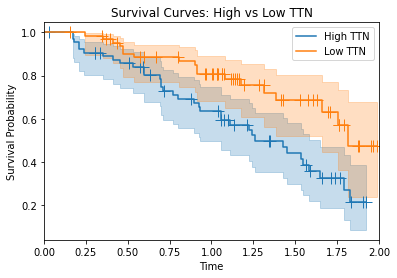

Significant gene for survival analysis TTN. Test statistic: 7.824770227261144. p-value: 0.005153499798414135


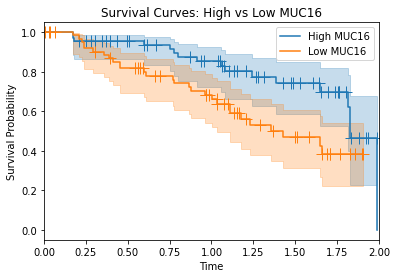

Significant gene for survival analysis MUC16. Test statistic: 6.464396308296317. p-value: 0.011005702351678633


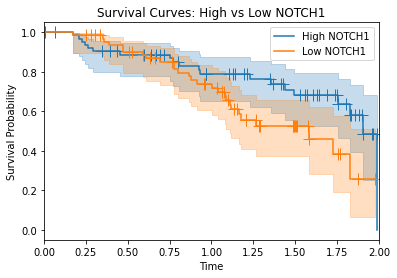

Significant gene for survival analysis NOTCH1. Test statistic: 3.894710255873999. p-value: 0.048438393699301134


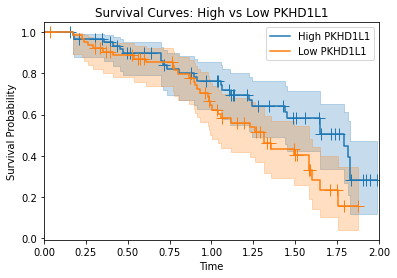

Significant gene for survival analysis PKHD1L1. Test statistic: 4.589616995915573. p-value: 0.03216620131878581


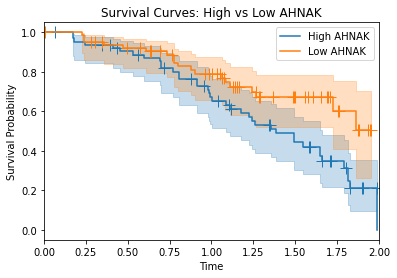

Significant gene for survival analysis AHNAK. Test statistic: 5.992449550855393. p-value: 0.014367237764140652


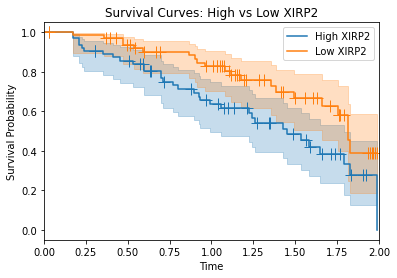

Significant gene for survival analysis XIRP2. Test statistic: 4.9142936188459085. p-value: 0.026635352522386798


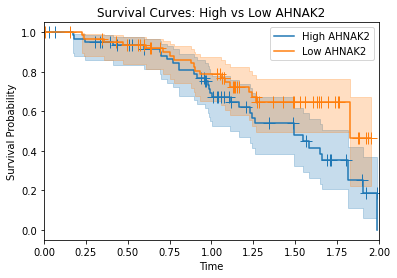

Significant gene for survival analysis AHNAK2. Test statistic: 4.023358874474948. p-value: 0.044874258747501124


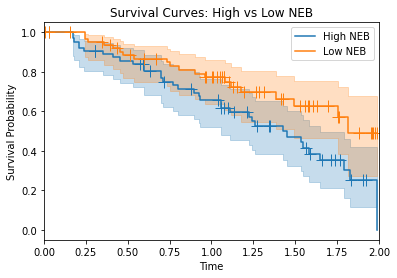

Significant gene for survival analysis NEB. Test statistic: 4.504580303377094. p-value: 0.03380419099407168


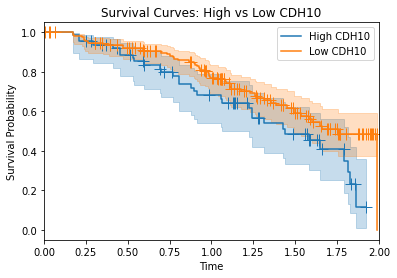

Significant gene for survival analysis CDH10. Test statistic: 4.372388272498695. p-value: 0.03652576464981089


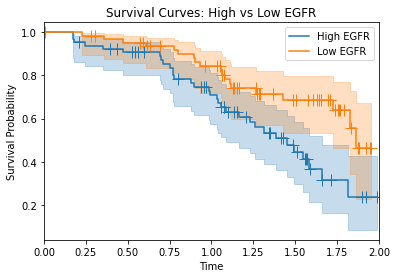

Significant gene for survival analysis EGFR. Test statistic: 7.068457238313833. p-value: 0.007845277971211127


In [88]:
# 2 years limit
data_two_years = full_data[full_data['DSS.time'] <= 2]

for i in gene_expression:
    data = ten_mutations(data_two_years, i)
    low_expression = data[data[i + 'binary'] == 0]
    high_expression =  data[data[i + 'binary'] == 1]
    # logrank
    results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                    high_expression['DSS'], low_expression['DSS'])
    p = results.p_value
    z_value = results.test_statistic
    if p <= 0.05:
        kmf = KaplanMeierFitter()
        kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High ' + i )
        kmf.plot(show_censors=True)
        kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low ' + i )
        kmf.plot(show_censors=True)
        # Add labels and legend
        plt.xlim(0,2)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.title('Survival Curves: High vs Low ' + i )
        plt.legend()

        # Show the plot
        plt.show()
        print("Significant gene for survival analysis " + i + ". Test statistic: " + str(z_value)+ ". p-value: " + str(results.p_value)) 

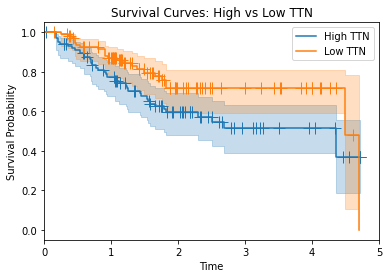

Significant gene for survival analysis TTN. Test statistic: 4.279125237675341. p-value: 0.03858320033097812


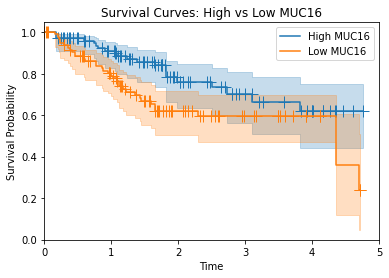

Significant gene for survival analysis MUC16. Test statistic: 5.142949920230256. p-value: 0.023340954684991897


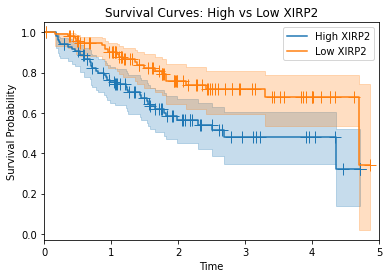

Significant gene for survival analysis XIRP2. Test statistic: 7.942969986771319. p-value: 0.004827454026246315


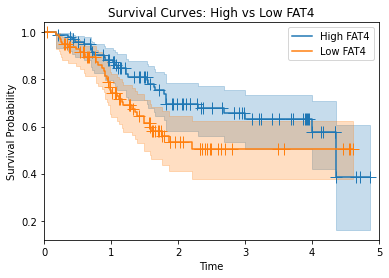

Significant gene for survival analysis FAT4. Test statistic: 3.8871775553969323. p-value: 0.04865612756617047


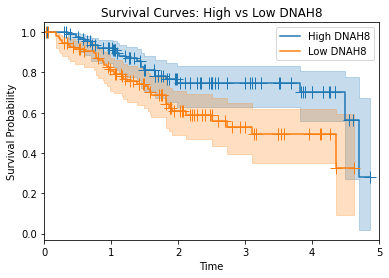

Significant gene for survival analysis DNAH8. Test statistic: 6.559246773061694. p-value: 0.010434052254748472


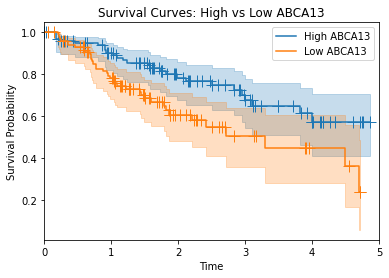

Significant gene for survival analysis ABCA13. Test statistic: 6.940399675575697. p-value: 0.008427028161252736


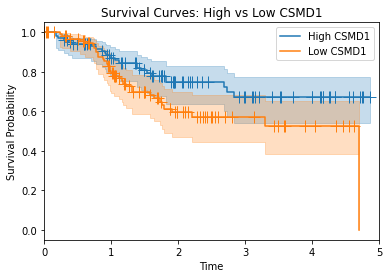

Significant gene for survival analysis CSMD1. Test statistic: 4.738299121910297. p-value: 0.02949822134026859


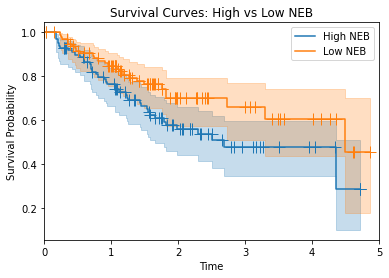

Significant gene for survival analysis NEB. Test statistic: 4.144840539394566. p-value: 0.04176158850683458


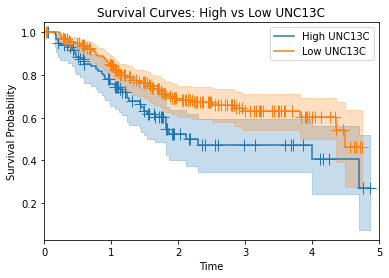

Significant gene for survival analysis UNC13C. Test statistic: 6.3618885058930585. p-value: 0.01165973766039178


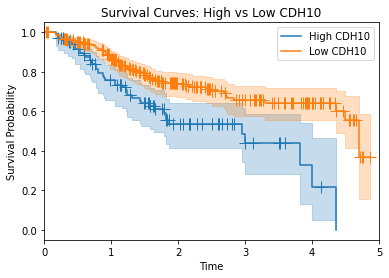

Significant gene for survival analysis CDH10. Test statistic: 13.700206550428332. p-value: 0.00021443090147571565


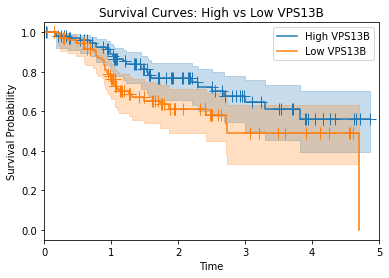

Significant gene for survival analysis VPS13B. Test statistic: 4.351463808776852. p-value: 0.036977150820687366


In [89]:
#5 years limit
data_five_years = full_data[full_data['DSS.time'] <= 5]

for i in gene_expression:
    data = ten_mutations(data_five_years, i)
    low_expression = data[data[i + 'binary'] == 0]
    high_expression =  data[data[i + 'binary'] == 1]
    # logrank
    results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                    high_expression['DSS'], low_expression['DSS'])
    p = results.p_value
    z_value = results.test_statistic
    if p <= 0.05:
        kmf = KaplanMeierFitter()
        kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High ' + i )
        kmf.plot(show_censors=True)
        kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low ' + i )
        kmf.plot(show_censors=True)
        # Add labels and legend
        plt.xlim(0,5)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.title('Survival Curves: High vs Low ' + i )
        plt.legend()

        # Show the plot
        plt.show()
        print("Significant gene for survival analysis " + i + ". Test statistic: " + str(z_value)+ ". p-value: " + str(results.p_value)) 

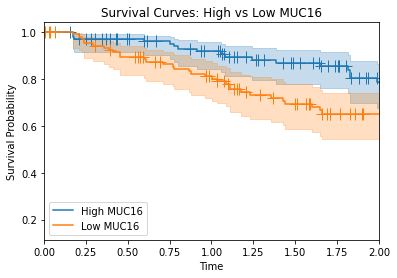

Significant gene for survival analysis MUC16. Test statistic: 4.653190580216915. p-value: 0.030995884387002272


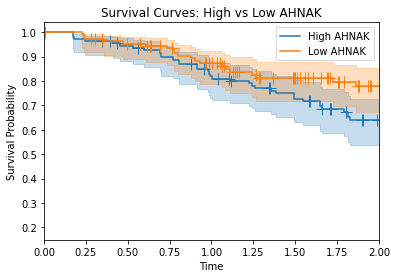

Significant gene for survival analysis AHNAK. Test statistic: 4.252695893941081. p-value: 0.039188074481107046


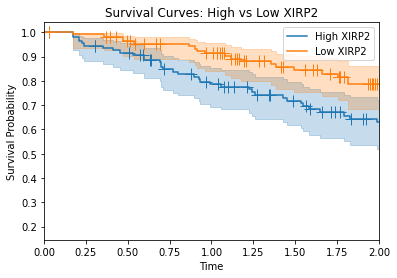

Significant gene for survival analysis XIRP2. Test statistic: 6.146855275188. p-value: 0.01316459831002211


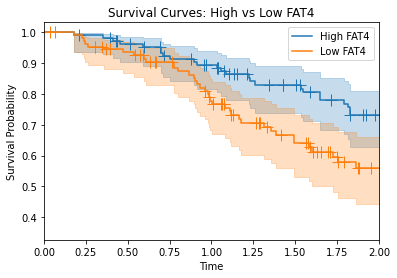

Significant gene for survival analysis FAT4. Test statistic: 4.706473601370522. p-value: 0.030049230468367348


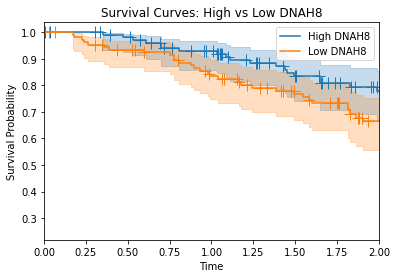

Significant gene for survival analysis DNAH8. Test statistic: 4.103162786331605. p-value: 0.04280307206846427


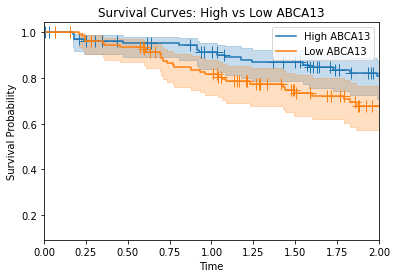

Significant gene for survival analysis ABCA13. Test statistic: 4.440495276602311. p-value: 0.035096064699945154


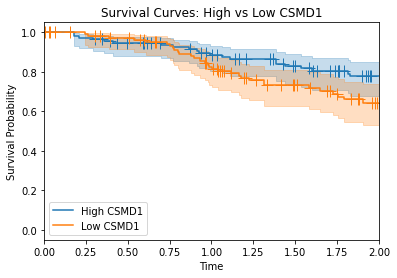

Significant gene for survival analysis CSMD1. Test statistic: 5.047695312314239. p-value: 0.024658716350627337


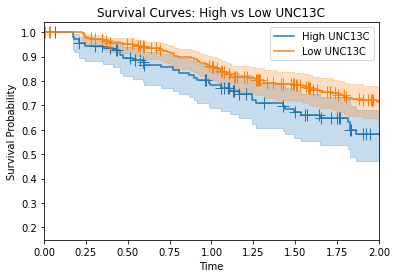

Significant gene for survival analysis UNC13C. Test statistic: 3.908131942208258. p-value: 0.04805298252449929


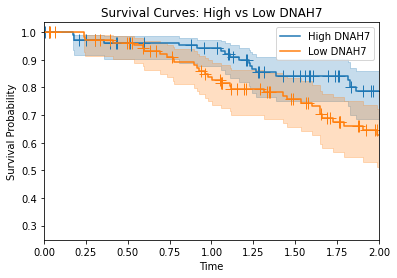

Significant gene for survival analysis DNAH7. Test statistic: 4.66503744558415. p-value: 0.03078275217527487


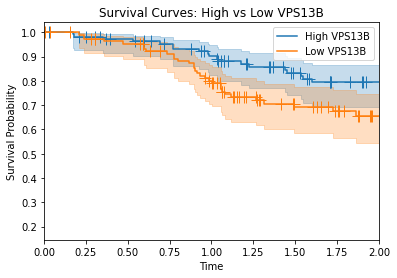

Significant gene for survival analysis VPS13B. Test statistic: 4.039619948238463. p-value: 0.044443829541617484


In [90]:
# 10 years limit
data_ten_years = full_data[full_data['DSS.time'] <= 10]

for i in gene_expression:
    data = ten_mutations(data_ten_years, i)
    low_expression = data[data[i + 'binary'] == 0]
    high_expression =  data[data[i + 'binary'] == 1]
    # logrank
    results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                    high_expression['DSS'], low_expression['DSS'])
    p = results.p_value
    z_value = results.test_statistic
    if p <= 0.05:
        kmf = KaplanMeierFitter()
        kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High ' + i )
        kmf.plot(show_censors=True)
        kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low ' + i )
        kmf.plot(show_censors=True)
        # Add labels and legend
        plt.xlim(0,2)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.title('Survival Curves: High vs Low ' + i )
        plt.legend()

        # Show the plot
        plt.show()
        print("Significant gene for survival analysis " + i + ". Test statistic: " + str(z_value)+ ". p-value: " + str(results.p_value)) 

# Classification

In [26]:
#select top n mutations by z values as features columns from full_data

df = full_data
features are from the data

In [91]:
def classification_svm(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    # SVM
   
    # Define the model
    svm_clf = svm.SVC()

    # Train the model
    svm_clf.fit(X_train, y_train)
   
    # Predict on the test set
    svm_predictions = svm_clf.predict(X_test)

    # Evaluate the model
    return confusion_matrix(y_test, svm_predictions), accuracy_score(y_test, svm_predictions)
    #print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

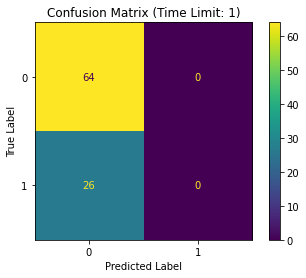

For time limit 1 and gene expression features from Log rank test: 
SVM Accuracy 0.7107777777777765


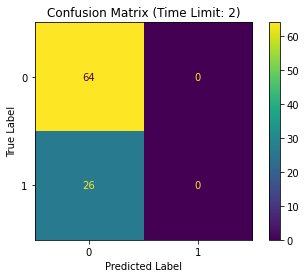

For time limit 2 and gene expression features from Log rank test: 
SVM Accuracy 0.7129999999999994


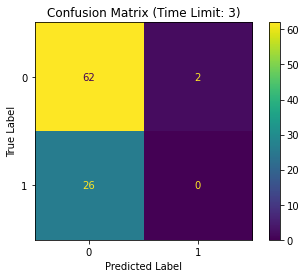

For time limit 3 and gene expression features from Log rank test: 
SVM Accuracy 0.708999999999999


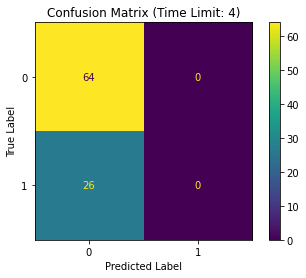

For time limit 4 and gene expression features from Log rank test: 
SVM Accuracy 0.7091111111111102


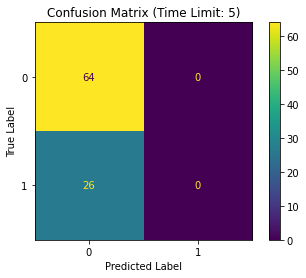

For time limit 5 and gene expression features from Log rank test: 
SVM Accuracy 0.7095555555555546


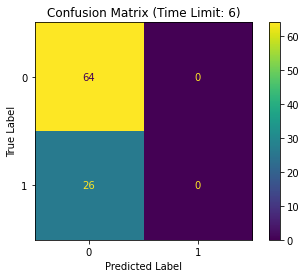

For time limit 6 and gene expression features from Log rank test: 
SVM Accuracy 0.7087777777777768


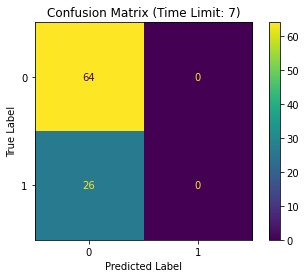

For time limit 7 and gene expression features from Log rank test: 
SVM Accuracy 0.7079999999999991


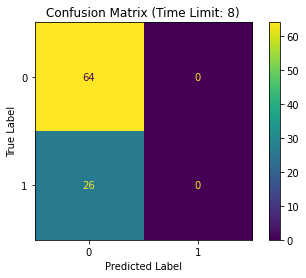

For time limit 8 and gene expression features from Log rank test: 
SVM Accuracy 0.7084444444444437


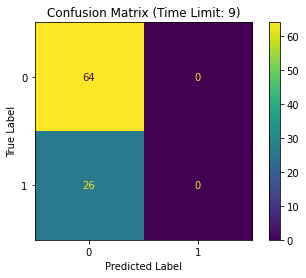

For time limit 9 and gene expression features from Log rank test: 
SVM Accuracy 0.7103333333333327


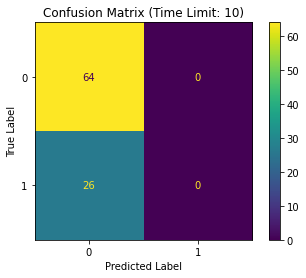

For time limit 10 and gene expression features from Log rank test: 
SVM Accuracy 0.7092222222222214


In [92]:
#acc svm for gene expression
acc_svm = []
for i in time_limit:
    lis = []
    for k in range(100):
        matrix, accuracy = classification_svm(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_svm.append(mean_acc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Time Limit: {i})')
    plt.show()
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test: ')
    print('SVM Accuracy ' + str(mean_acc))

In [93]:
def classification_logistic(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    log_reg = LogisticRegression()

    # Train the model
    log_reg.fit(X_train, y_train)
    log_reg_predictions = log_reg.predict(X_test)

    # Evaluate the model
    return confusion_matrix(y_test, log_reg_predictions), accuracy_score(y_test, log_reg_predictions)
    #print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_predictions))

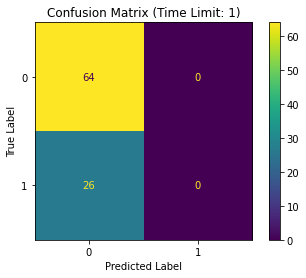

For time limit 1 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7083333333333325


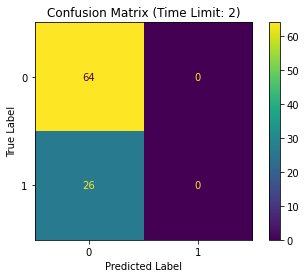

For time limit 2 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7161111111111107


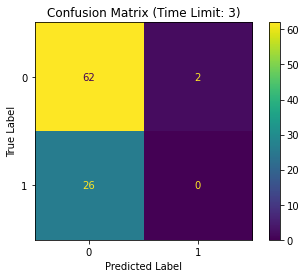

For time limit 3 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7076666666666661


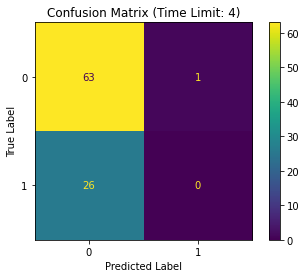

For time limit 4 and gene expression features from Log rank test
Logistic Regression Accuracy 0.6983333333333333


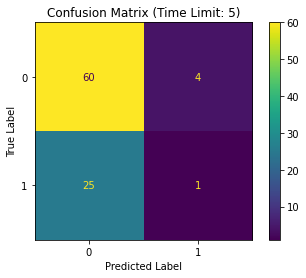

For time limit 5 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7007777777777775


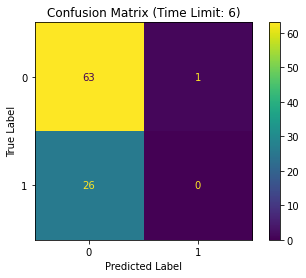

For time limit 6 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7015555555555558


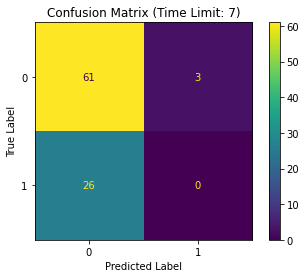

For time limit 7 and gene expression features from Log rank test
Logistic Regression Accuracy 0.6942222222222224


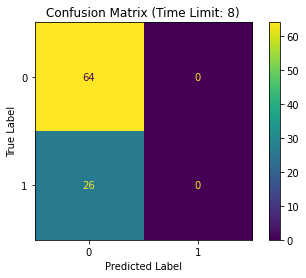

For time limit 8 and gene expression features from Log rank test
Logistic Regression Accuracy 0.705555555555555


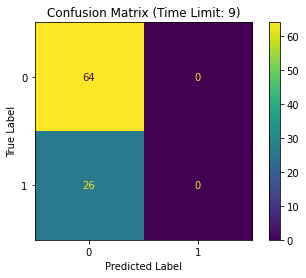

For time limit 9 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7027777777777776


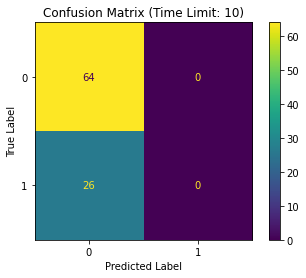

For time limit 10 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7043333333333328


In [94]:
acc_logi = []
for i in time_limit:
    lis = []
    for k in range(100):
        matrix, accuracy = classification_logistic(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_logi.append(mean_acc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Time Limit: {i})')
    plt.show()
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test')
    print('Logistic Regression Accuracy ' + str(mean_acc))

In [95]:
def classifcation_randomforest(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_clf = RandomForestClassifier()

    # Train the model
    rf_clf.fit(X_train, y_train)
    # Predict on the test set
    rf_predictions = rf_clf.predict(X_test)

    # Evaluate the model
    return confusion_matrix(y_test, rf_predictions),accuracy_score(y_test, rf_predictions)
    #print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

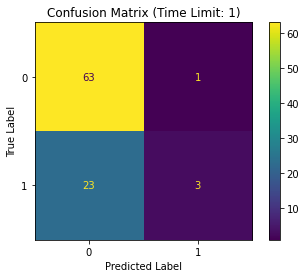

For time limit 1 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6835555555555557


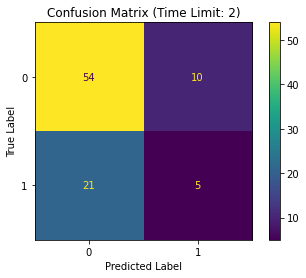

For time limit 2 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6616666666666666


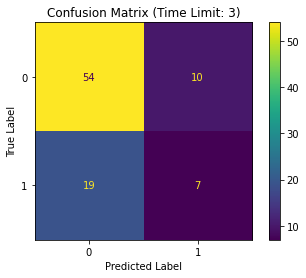

For time limit 3 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6691111111111112


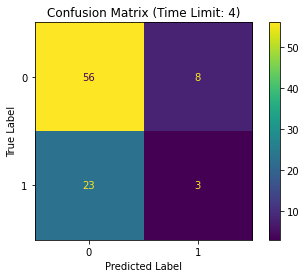

For time limit 4 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6934444444444443


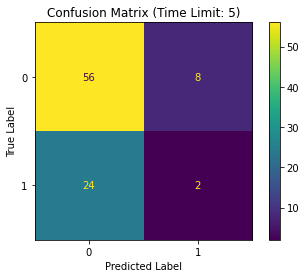

For time limit 5 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6811111111111114


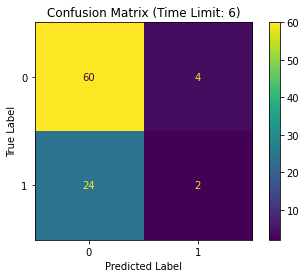

For time limit 6 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6826666666666666


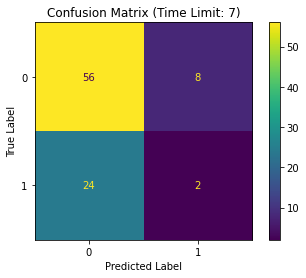

For time limit 7 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6763333333333336


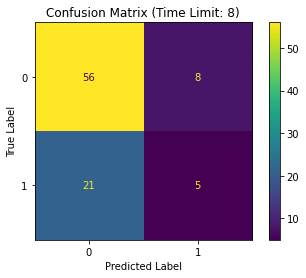

For time limit 8 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6691111111111111


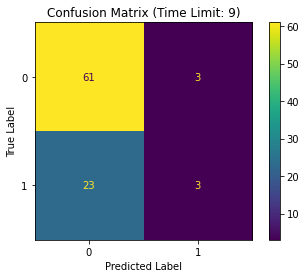

For time limit 9 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6713333333333334


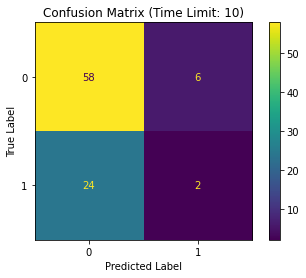

For time limit 10 and gene expression features from Log rank test: 
Random Forest Accuracy 0.6706666666666671


In [96]:
acc_random = []
for i in time_limit:
    lis = []
    for k in range(100): #change to 100 
        matrix, accuracy = classifcation_randomforest(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_random.append(mean_acc)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Time Limit: {i})')
    plt.show()
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test: ') #change to logrank
    print('Random Forest Accuracy ' + str(mean_acc))

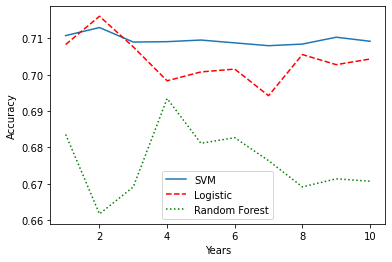

In [97]:
plt.plot(time_limit, acc_svm, label='SVM')  # Default color and line style
plt.plot(time_limit, acc_logi, 'r--', label='Logistic')  # Red dashed line
plt.plot(time_limit, acc_random, 'g:', label='Random Forest')  # Green dotted line

# Optional: add a legend to explain which line is which
plt.legend()
plt.xlabel('Years')
plt.ylabel('Accuracy')
# Show the plot
plt.show()

# Best parameters for Random Forest

In [98]:
def best_estimator(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_clf = RandomForestClassifier()
    param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
    # Train the model
    CV_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv = 5)
    CV_rf.fit(X_train, y_train)
    # Predict on the test set
    return CV_rf.best_params_

In [99]:
# get the best parameter for each time based on each feature
para_dic = {}
for i in time_limit:
    para_dic[i] = best_estimator(test_data, feature_dic[i])

In [100]:
pd.DataFrame(para_dic)

,1,2,3,4,5,6,7,8,9,10
criterion,entropy,gini,entropy,gini,entropy,gini,entropy,gini,gini,gini
max_depth,7,4,7,7,8,4,8,4,5,6
max_features,auto,auto,log2,auto,auto,sqrt,sqrt,log2,log2,log2
n_estimators,200,50,200,50,50,50,100,50,10,100


In [101]:
def classifcation_randomforestcv(df, features, best_para):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_best = RandomForestClassifier(n_estimators= best_para['n_estimators'], max_features=best_para['max_features'], max_depth=best_para['max_depth'], criterion=best_para['criterion'])
    rf_best.fit(X_train, y_train)

    predictions = rf_best.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cv_score = cross_val_score(rf_best, X, y, cv=5)
    # Evaluate the model
    return accuracy, cv_score.mean()

In [102]:
acc_grid = []
acc_cv = []
for i in time_limit:
    lis_grid = []
    lis_cv = []
    for k in range(10):
        grid_accuracy, cv_score = classifcation_randomforestcv(test_data, feature_dic[i],para_dic[i])
        lis_grid.append(grid_accuracy)
        lis_cv.append(cv_score)
    mean_grid = sum(lis_grid)/len(lis_grid)
    mean_cv =  sum(lis_cv)/len(lis_cv)
    acc_grid.append(mean_grid)
    acc_cv.append(mean_cv)
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test: ')
    print('Random Forest GridSearchCV Accuracy ' + str(mean_grid))
    print('Random Forest cross validation Accuracy ' + str(mean_cv))

For time limit 1 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7144444444444444
Random Forest cross validation Accuracy 0.7013333333333334
For time limit 2 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.698888888888889
Random Forest cross validation Accuracy 0.6933333333333332
For time limit 3 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7188888888888889
Random Forest cross validation Accuracy 0.6997777777777777
For time limit 4 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.708888888888889
Random Forest cross validation Accuracy 0.7
For time limit 5 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7055555555555556
Random Forest cross validation Accuracy 0.6928888888888888
For time limit 6 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7088888

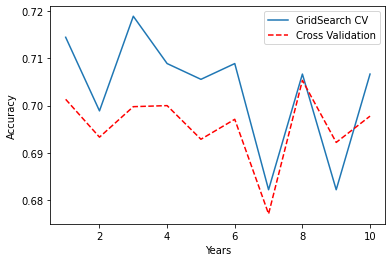

In [103]:
plt.plot(time_limit, acc_grid, label='GridSearch CV')  # Default color and line style
plt.plot(time_limit, acc_cv, 'r--', label='Cross Validation')  # Red dashed line

# Optional: add a legend to explain which line is which
plt.legend()
plt.xlabel('Years')
plt.ylabel('Accuracy')
# Show the plot
plt.show()